# Libraries

In [ ]:
from transformers import set_seed
import torch, transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import json,re, ast,os,time
from sklearn.metrics import classification_report, confusion_matrix

set_seed(42)  # Setting a fixed seed for consistency


/home/ehossain/.conda/envs/aspect-sim/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Path Organization
current_dir = os.getcwd()

# Get the root directory by navigating up the directory tree
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))  
root_dir = os.path.abspath(os.path.join(root_dir,'Computational-NLU-Project'))  
dataset_dir = os.path.join(root_dir,'Datasets')
results_dir = os.path.join(root_dir,'Results')
prompt_dir = os.path.join(root_dir,'Prompts')


# Result Analysis

In [3]:
llm_names = ['llama32-3B', 'mistral-7B','deepseek-8B',  'phi4-14B','gemma2-27B', 'qwen-72B']

## Helper Functions

In [4]:
## Classwise f1 Score

def classwise_f1_pivot(data,classes):

    f1_list, category, llms,wf1_list = [],[],[],[]
    for col in llm_names:
        d = classification_report(y_true=data['label'],y_pred=data[col],
                                digits=4, output_dict = True)
        wf1 = "{:.2f}".format(d['weighted avg']['f1-score'] * 100)
        for label in classes:
            f1 = "{:.2f}".format(d[label]['f1-score'] * 100)
            f1_list.append(float(f1))
            category.append(label.capitalize())
            llms.append(col.capitalize())
        wf1_list.append((col,wf1))    


    # making pivot
    make_pivot = pd.DataFrame({'F1-Score':f1_list,'Category':category,'LLMs':llms})
    df_pivot = make_pivot.pivot(index='LLMs', columns='Category', values='F1-Score').reset_index()
    df = pd.melt(df_pivot, id_vars='LLMs', var_name="Category", value_name="Values")

    # LLM names
    u_llm =  ['Llama32-3b',  'Mistral-7b','Deepseek-8b','Phi4-14b', 'Gemma2-27b', 'Qwen-72b']
    
    # Ensure LLMs is a Categorical type with your desired order
    df['LLMs'] = pd.Categorical(df['LLMs'], categories=u_llm, ordered=True)

    # Sort by this custom category
    df = df.sort_values('LLMs') 

    return df,wf1_list

## Sentiment Analysis

In [5]:
# Zero Shot Sentiment Results
zero_senti = pd.read_excel(os.path.join(results_dir,'senti_zero_shot.xlsx'))
# Few Shot Sentiment Results
few_senti = pd.read_excel(os.path.join(results_dir,'senti_few_shot.xlsx'))

# Class Names
senti_classes = ['positive', 'negative', 'neutral'] 
# zero_senti

### Classification Report

In [ ]:
## Classification Report

for col in llm_names:
    print('-----------')
    print(col)
    print('------------')
    #print(classification_report(y_true=zero_senti['label'],y_pred=zero_senti[col],digits=4))
    print(classification_report(y_true=few_senti['label'],y_pred=few_senti[col],digits=4))
    # print('--------------------')

### Confusion Matrix

In [72]:
## Confusion matrix function
def con_mat_senti(cm, class_names,model_name):
  #sns.set()
  plt.figure(figsize =(2, 1))
  ax = plt.subplot()
 # 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            #'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
  sns.heatmap(cm, annot=True,fmt="d",cmap='YlGnBu', ax = ax,
              annot_kws={"size": 11}, square=False,cbar=False) #annot=True to annotate cells
  # labels, title and ticks
  ax.set_xlabel('',fontsize=10)
  ax.set_ylabel('',fontsize=10)
  #ax.set_title(f'Confusion Matrix of {model_name}',fontsize=10)
  ax.xaxis.set_ticklabels(class_names, rotation=30); ax.yaxis.set_ticklabels(class_names, rotation=30);
  ax.xaxis.tick_top()
  plt.savefig(os.path.join(results_dir,f"{model_name}.png"),bbox_inches='tight',dpi =500)



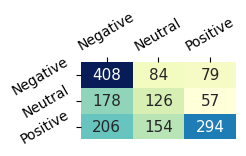

In [ ]:
## Zero shot worst model 
v_model = confusion_matrix(zero_senti['Label'],zero_senti['llama32-3B'])
class_names =['Negative','Neutral','Positive']
con_mat_senti(v_model, class_names,"senti_llama_conf")
#v_model

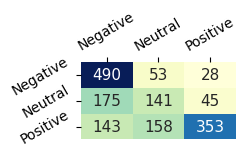

In [ ]:
## Zero shot best model 
v_model = confusion_matrix(zero_senti['Label'],zero_senti['gemma2-27B'])
class_names =['Negative','Neutral','Positive']
con_mat_senti(v_model, class_names,"senti_gemma_conf")
#v_model

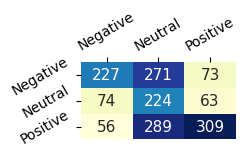

In [73]:
## Few shot worst model 
v_model = confusion_matrix(few_senti['label'],few_senti['mistral-7B'])
class_names =['Negative','Neutral','Positive']
con_mat_senti(v_model, class_names,"1_senti_mistral_conf_few")
#v_model

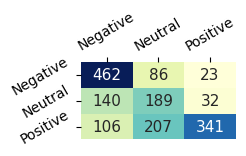

In [74]:
## Few shot best model 
v_model = confusion_matrix(few_senti['label'],few_senti['gemma2-27B'])
class_names =['Negative','Neutral','Positive']
con_mat_senti(v_model, class_names,"1_senti_gemma_conf_few")
#v_model

### Classwise F1 

In [39]:
## Class wise Performance Plot
def classwise_plot(df, plt_name, y_limit, figsize ,save = False):

    model_names = ['Llama-3.2-3b','Mistral-V3-7b','DeepSeek-R1-8b','Phi-4-14b','Gemma-2-27b','Qwen-2.5-72b']
    plt.figure(figsize=figsize)

    # bar plot
    splot = sns.barplot(data=df,x='LLMs', y='Values' ,hue='Category',
                        palette="pastel",edgecolor = 'black')
    # Define some hatches
    hatches = ['//','.','\\']
    # hatches = ['//','','','\\','.']

    # Loop over the bars and apply hatches cyclically
    print(len(splot.patches))
    for i, thisbar in enumerate(splot.patches):
        hatch = hatches[(i // 6) % len(hatches)]# Cycle through hatches
        # print(hatch)
        thisbar.set_hatch(hatch)

    # Annotate bars with F1-scores
    for bar in splot.patches:
      height = bar.get_height()
      if not np.isnan(height):
          x = bar.get_x() + bar.get_width() / 2  # center of individual bar
          splot.annotate(f'{height:.1f}',
                        xy=(x, height),
                        xytext=(1, 5),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=7,
                        rotation=90)  

    # plt.title(plt_name)
    plt.xlabel('')
    plt.ylabel('F1-Score (%)',fontsize=8)
    plt.ylim(y_limit)
    ax = plt.gca()
    ax.spines['bottom'].set_color("gray")
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    handles, labels = splot.get_legend_handles_labels()
    for handle, hatch in zip(handles, hatches):
      handle.set_hatch(hatch)  # Apply the same hatch pattern to the legend entries

    # Adjust legend to horizontal and reduce gaps between legend items
    plt.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 1.2), shadow=True,
               ncol=4, fontsize=8, handletextpad=0.5, columnspacing=0.8, handlelength=1.5, handleheight=1.2)
    plt.tight_layout()  # Ensures all elements fit within the figure area
    plt.xticks([0,1,2,3,4,5],model_names ,rotation = 30, ha='right',fontsize=9)
    if save:
      plt.savefig(os.path.join(results_dir,f'{plt_name}.png'),dpi = 500,bbox_inches ='tight')

In [7]:
## zero shot pivot
df_sz,llm_sz = classwise_f1_pivot(zero_senti,senti_classes)
## few shot pivot
df_sf,llm_sf = classwise_f1_pivot(few_senti,senti_classes)

In [ ]:
sz = [('llama32-3B', '51.83'),('mistral-7B', '52.25'), ('deepseek-8B', '52.15'), ('phi4-14B', '60.28'), ('gemma2-27B', '61.54'), ('qwen-72B', '59.32')]
sf = [('llama32-3B', '57.19'),('mistral-7B', '49.71'), ('deepseek-8B', '51.71'), ('phi4-14B', '58.88'), ('gemma2-27B', '63.00'), ('qwen-72B', '61.30')]

In [71]:
llm_sz

[('llama32-3B', '51.83'),
 ('mistral-7B', '52.25'),
 ('deepseek-8B', '52.15'),
 ('phi4-14B', '60.28'),
 ('gemma2-27B', '61.54'),
 ('qwen-72B', '59.32')]

In [70]:
llm_sf

[('llama32-3B', '57.19'),
 ('mistral-7B', '49.71'),
 ('deepseek-8B', '51.71'),
 ('phi4-14B', '58.88'),
 ('gemma2-27B', '63.00'),
 ('qwen-72B', '61.30')]

### Plotting

21


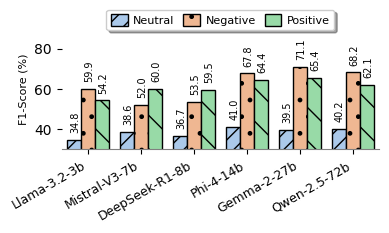

In [40]:
# Classwise performace for zero shot
classwise_plot(df_sz,'1_senti_classwise_zero',y_limit=[30,90],figsize=(4, 2),save = True)


21


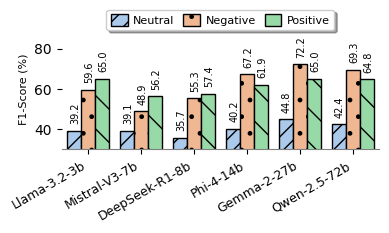

In [41]:
# Classwise performace for zero shot
classwise_plot(df_sf,'1_senti_classwise_few',y_limit=[30,90],figsize=(4, 2), save = True)

## Emotion Recognition

In [42]:
# Zero Shot Emotion Results
zero_emo = pd.read_excel(os.path.join(results_dir,'emo_zero_shot.xlsx'))
few_emo = pd.read_excel(os.path.join(results_dir,'emo_few_shot.xlsx'))
emo_classes = ['disgust', 'sadness', 'joy', 'fear', 'surprise', 'anger']
zero_emo.head(5)

,sentence,label,qwen-72B,llama32-3B,mistral-7B,phi4-14B,deepseek-8B,gemma2-27B
0,দুই বছরের ব্যবধানে বগুড়া থেকে বিদেশে পণ্য রপ্ত...,joy,joy,joy,anger,joy,joy,joy
1,আওয়ামী লীগ সরকার বাংলাদেশকে অন্ধকার কুয়া থেকে ...,joy,joy,joy,anger,joy,joy,joy
2,চোখ কচলাতে কচলাতে বেশ রাগান্বীত কন্ঠ বলল ধুরো ...,disgust,anger,anger,sadness,sadness,anger,anger
3,মেয়েটা অতিরিক্ত আত্মপরিচয় সংকটে ভুগে সাবিলা স্...,disgust,sadness,sadness,fear,sadness,joy,disgust
4,এবার উন্নয়ন মুলক কাজের কিছু দৃশ্যমান পরিদশন ক...,joy,joy,disgust,anger,joy,anger,joy


### Classification Report

In [ ]:
## Classification Report

for col in llm_names:
    print('-----------')
    print(col)
    print('------------')
    #print(classification_report(y_true=zero_emo['label'],y_pred=zero_emo[col],digits=4))
    print(classification_report(y_true=few_emo['label'],y_pred=few_emo[col],digits=4))
    # print('--------------------')

### Classwise F1

In [43]:
## zero shot pivot
df_ez,llm_ez = classwise_f1_pivot(zero_emo,emo_classes)
## few shot pivot
df_ef,llm_ef = classwise_f1_pivot(few_emo,emo_classes)

In [188]:
llm_ef

[('llama32-3B', '47.12'),
 ('mistral-7B', '46.41'),
 ('deepseek-8B', '43.41'),
 ('phi4-14B', '54.56'),
 ('gemma2-27B', '60.27'),
 ('qwen-72B', '65.86')]

In [ ]:
ez = [('llama32-3B', '44.28'),('mistral-7B', '33.89'), ('deepseek-8B', '42.14'),('phi4-14B', '56.96'),('gemma2-27B', '58.40'), ('qwen-72B', '59.44')]
ef = [('llama32-3B', '47.12'), ('mistral-7B', '46.41'), ('deepseek-8B', '43.41'),('phi4-14B', '54.56'),('gemma2-27B', '60.27'),('qwen-72B', '65.86')]

In [47]:
def classwise_plot_emo(df, plt_name, y_limit, save = False):

    model_names = ['Llama-3.2-3b','Mistral-V3-7b','DeepSeek-R1-8b','Phi-4-14b','Gemma-2-27b','Qwen-2.5-72b']
    plt.figure(figsize=(8, 3))

    # bar plot
    splot = sns.barplot(data=df,x='LLMs', y='Values' ,hue='Category',
                        palette="pastel",edgecolor = 'black')
    # Define some hatches
    #hatches = ['//','.','\\']
    hatches = ['//','','.','\\','.','']

    # Loop over the bars and apply hatches cyclically
    # print(len(splot.patches))
    for i, thisbar in enumerate(splot.patches):
        hatch = hatches[(i // 6) % len(hatches)]# Cycle through hatches
        # print(hatch)
        thisbar.set_hatch(hatch)

    # Annotate bars with F1-scores
    for bar in splot.patches:
      height = bar.get_height()
      if not np.isnan(height):
          x = bar.get_x() + bar.get_width() / 2  # center of individual bar
          splot.annotate(f'{height:.1f}',
                        xy=(x, height),
                        xytext=(1, 5),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=7,
                        rotation=90)      

    # plt.title(plt_name)
    plt.xlabel('')
    plt.ylabel('F1-Score (%)')
    plt.ylim(y_limit)
    ax = plt.gca()
    ax.spines['bottom'].set_color("gray")
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    handles, labels = splot.get_legend_handles_labels()
    for handle, hatch in zip(handles, hatches):
      handle.set_hatch(hatch)  # Apply the same hatch pattern to the legend entries

    # Adjust legend to horizontal and reduce gaps between legend items
    plt.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 1.2), shadow=True,
               ncol=6, fontsize=8, handletextpad=0.5, columnspacing=0.8, handlelength=1.5, handleheight=1.2)
    plt.tight_layout()  # Ensures all elements fit within the figure area
    plt.xticks([0,1,2,3,4,5],model_names ,rotation = 30, ha='right')
    if save:
      plt.savefig(os.path.join(results_dir,f'{plt_name}.png'),dpi = 500,bbox_inches ='tight')

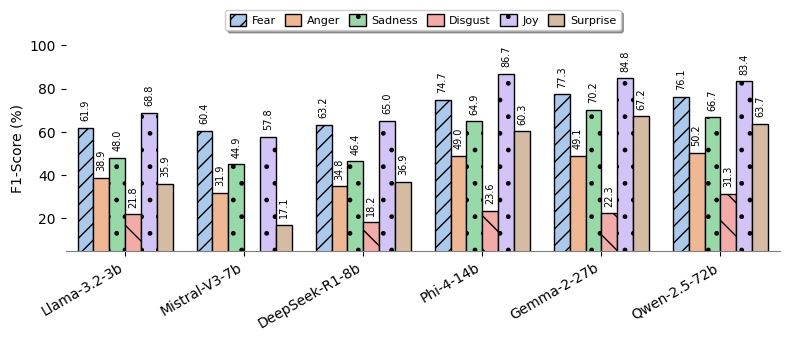

In [32]:
# classwise performance
classwise_plot_emo(df_ez,'2_emo_classwise_zero', y_limit=[5,100], save = True)

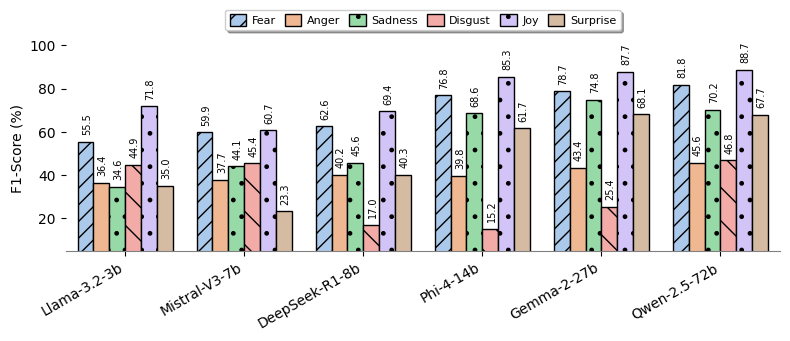

In [49]:
# classwise performance
classwise_plot_emo(df_ef,'2_emo_classwise_few', y_limit=[5,100], save = True)

### Confusion Matrix

In [77]:
## Confusion matrix function
def con_mat_emo(cm, class_names,model_name):
  #sns.set()
  plt.figure(figsize =(3, 2))
  ax = plt.subplot()
 # 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            #'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
  sns.heatmap(cm, annot=True,fmt="d",cmap='YlGnBu', ax = ax,
              annot_kws={"size": 11}, square=False,cbar=False) #annot=True to annotate cells
  # labels, title and ticks
  ax.set_xlabel('',fontsize=10)
  ax.set_ylabel('',fontsize=10)
  #ax.set_title(f'Confusion Matrix of {model_name}',fontsize=10)
  ax.xaxis.set_ticklabels(class_names, rotation=30); ax.yaxis.set_ticklabels(class_names, rotation=30);
  ax.xaxis.tick_top()
  plt.savefig(os.path.join(results_dir,f"{model_name}.png"),bbox_inches='tight',dpi =500)

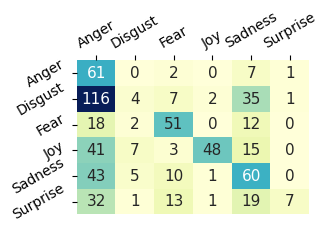

In [ ]:
## zero shot worst model
v_model = confusion_matrix(zero_emo['classes'],zero_emo['mistral-7B'])
class_names =['Anger','Disgust','Fear','Joy','Sadness','Surprise']
con_mat_emo(v_model, class_names,"emo_mistral_conf")
#v_model

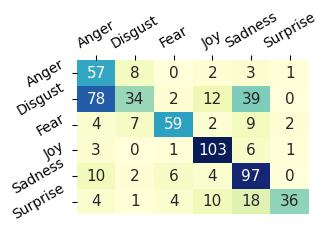

In [ ]:
## zero shot best model
v_model = confusion_matrix(zero_emo['classes'],zero_emo['qwen-72B'])
class_names =['Anger','Disgust','Fear','Joy','Sadness','Surprise']
con_mat_emo(v_model, class_names,"emo_qwen_conf")
#v_model

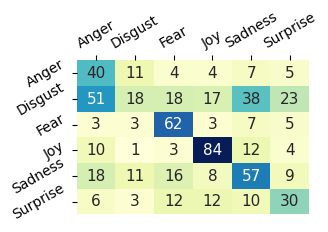

In [78]:
## few shot worst model
v_model = confusion_matrix(few_emo['label'],few_emo['deepseek-8B'])
class_names =['Anger','Disgust','Fear','Joy','Sadness','Surprise']
con_mat_emo(v_model, class_names,"2_emo_deep_conf_few")
#v_model

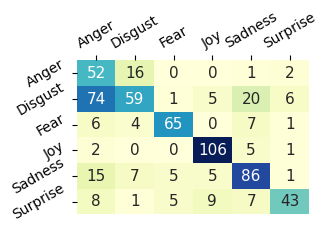

In [ ]:
## few shot best model
v_model = confusion_matrix(few_emo['label'],few_emo['qwen-72B'])
class_names =['Anger','Disgust','Fear','Joy','Sadness','Surprise']
con_mat_emo(v_model, class_names,"2_emo_qwen_conf_few")
#v_model

## Hate Speech Detection

In [4]:
# Zero/Few Shot hate speech Results
zero_hate = pd.read_excel(os.path.join(results_dir,'hate_zero_shot.xlsx'))
few_hate = pd.read_excel(os.path.join(results_dir,'hate_few_shot.xlsx'))
hate_classes = ['hate', 'not-hate']
zero_hate.head(5)

,sentence,label,llama32-3B,phi4-14B,deepseek-8B,mistral-7B,qwen-72B,gemma2-27B
0,দুধ না আজা কাঁঠাল ওহ,hate,not-hate,not-hate,not-hate,not-hate,not-hate,not-hate
1,সাকিবের সাথে অপু মাগির মিল চাই না এই মাগি খুব ...,hate,not-hate,hate,not-hate,hate,hate,hate
2,শেষের মাগীর নাম কি যানিনা আরে সালি কার সাথে কা...,hate,hate,hate,hate,hate,hate,hate
3,খানকি এসব বালছাল খবর কোথায় পাস তোর মাথায় কিছ...,hate,hate,hate,hate,hate,hate,hate
4,হাত পা কাপতেছে আমারএটা কি দেখলাম,not-hate,not-hate,not-hate,not-hate,not-hate,not-hate,not-hate


### Classification Report

In [ ]:
## classification report
for col in llm_names:
    print('-----------')
    print(col)
    print('------------')
    #print(classification_report(y_true=zero_hate['label'],y_pred=zero_hate[col],digits=4))
    print(classification_report(y_true=few_hate['label'],y_pred=few_hate[col],digits=4))
    # print('--------------------')

### Classwise F1

In [51]:
## zero shot pivot
df_hz,llm_hz = classwise_f1_pivot(zero_hate,hate_classes)
## few shot pivot
df_hf,llm_hf = classwise_f1_pivot(few_hate,hate_classes)

In [191]:
llm_hf

[('llama32-3B', '62.85'),
 ('mistral-7B', '63.07'),
 ('deepseek-8B', '61.47'),
 ('phi4-14B', '70.56'),
 ('gemma2-27B', '73.39'),
 ('qwen-72B', '78.25')]

In [44]:
llm_hz

[('llama32-3B', '54.22'),
 ('mistral-7B', '64.19'),
 ('deepseek-8B', '56.40'),
 ('phi4-14B', '72.17'),
 ('gemma2-27B', '76.11'),
 ('qwen-72B', '79.88')]

In [ ]:
hz = [('llama32-3B', '54.22'),('mistral-7B', '64.19'), ('deepseek-8B', '56.40'), ('phi4-14B', '72.17'),('gemma2-27B', '76.11'),('qwen-72B', '79.88')]
hf = [('llama32-3B', '62.85'),('mistral-7B', '63.07'), ('deepseek-8B', '61.47'),('phi4-14B', '70.56'),('gemma2-27B', '73.39'),('qwen-72B', '78.25')]

In [52]:
## Class wise Performance Plot
def classwise_plot_hate(df, plt_name, y_limit ,save = False):

    model_names = ['Llama-3.2-3b','Mistral-V3-7b','DeepSeek-R1-8b','Phi-4-14b','Gemma-2-27b','Qwen-2.5-72b']
    plt.figure(figsize=(4,2))

    # bar plot
    splot = sns.barplot(data=df,x='LLMs', y='Values' ,hue='Category',
                        palette="pastel",edgecolor = 'black')
    # Define some hatches
    hatches = ['//','.','\\']
    # hatches = ['//','','','\\','.']

    # Loop over the bars and apply hatches cyclically
    print(len(splot.patches))
    for i, thisbar in enumerate(splot.patches):
        hatch = hatches[(i // 6) % len(hatches)]# Cycle through hatches
        # print(hatch)
        thisbar.set_hatch(hatch)

    # Annotate bars with F1-scores
    for bar in splot.patches:
      height = bar.get_height()
      if not np.isnan(height):
          x = bar.get_x() + bar.get_width() / 2  # center of individual bar
          splot.annotate(f'{height:.1f}',
                        xy=(x, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=7,
                        rotation=90)  

    # plt.title(plt_name)
    plt.xlabel('')
    plt.ylabel('F1-Score (%)')
    plt.ylim(y_limit)
    ax = plt.gca()
    ax.spines['bottom'].set_color("gray")
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    handles, labels = splot.get_legend_handles_labels()
    for handle, hatch in zip(handles, hatches):
      handle.set_hatch(hatch)  # Apply the same hatch pattern to the legend entries

    # Adjust legend to horizontal and reduce gaps between legend items
    plt.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 1.2), shadow=True,
               ncol=4, fontsize=8, handletextpad=0.5, columnspacing=0.8, handlelength=1.5, handleheight=1.2)
    plt.tight_layout()  # Ensures all elements fit within the figure area
    plt.xticks([0,1,2,3,4,5],model_names ,rotation = 45, ha='right' ,fontsize=9)
    if save:
      plt.savefig(os.path.join(results_dir,f'{plt_name}.png'),dpi = 500,bbox_inches ='tight')

14


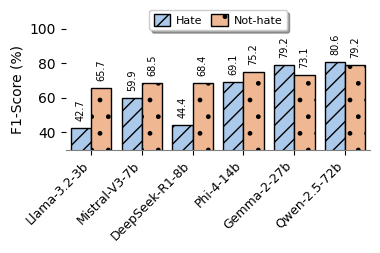

In [53]:
# classwise performance
classwise_plot_hate(df_hz,'3_hate_classwise_zero',y_limit=[30,100],save = True)

14


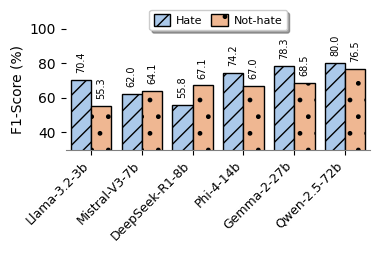

In [54]:
# classwise performance
classwise_plot_hate(df_hf,'3_hate_classwise_few',y_limit=[30,100],save = True)

### Confusion Matrix

In [23]:
## Confusion matrix function
def con_mat_hate(cm, class_names,model_name):
  #sns.set()
  plt.figure(figsize =(2, 1))
  ax = plt.subplot()
 # 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            #'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
  sns.heatmap(cm, annot=True,fmt="d",cmap='YlGnBu', ax = ax,
              annot_kws={"size": 11}, square=True,cbar=False) #annot=True to annotate cells
  # labels, title and ticks
  ax.set_xlabel('',fontsize=10)
  ax.set_ylabel('',fontsize=10)
  #ax.set_title(f'Confusion Matrix of {model_name}',fontsize=10)
  ax.xaxis.set_ticklabels(class_names, rotation=30,fontsize=8); ax.yaxis.set_ticklabels(class_names, rotation=30,fontsize=8);
  ax.xaxis.tick_top()
  plt.savefig(os.path.join(results_dir,f"{model_name}.png"),bbox_inches='tight',dpi =500)



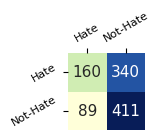

In [22]:
## zero shot worst model
v_model = confusion_matrix(zero_hate['label'],zero_hate['llama32-3B'])
class_names =['Hate','Not-Hate']
con_mat_hate(v_model, class_names,"hate_llama_conf")
#v_model

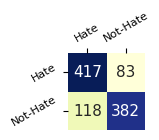

In [24]:
## zero shot best model
v_model = confusion_matrix(zero_hate['label'],zero_hate['qwen-72B'])
class_names =['Hate','Not-Hate']
con_mat_hate(v_model, class_names,"hate_qwen_conf_zero")
#v_model

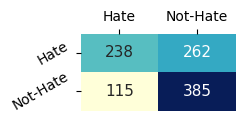

In [81]:
## few shot worst model
v_model = confusion_matrix(few_hate['label'],few_hate['deepseek-8B'])
class_names =['Hate','Not-Hate']
con_mat_hate(v_model, class_names,"3_hate_deep_conf_few")
#v_model

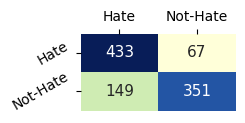

In [82]:
## few shot best model
v_model = confusion_matrix(few_hate['label'],few_hate['qwen-72B'])
class_names =['Hate','Not-Hate']
con_mat_hate(v_model, class_names,"3_hate_qwen_conf_few")
#v_model

## Fake News Detection

In [25]:
# Zero/Few Shot hate speech Results
zero_fake = pd.read_excel(os.path.join(results_dir,'fake_zero_shot.xlsx'))
few_fake = pd.read_excel(os.path.join(results_dir,'fake_few_shot.xlsx'))
fake_classes = ['fake', 'real']
zero_fake.head(5)

,sentence,label,llama32-3B,mistral-7B,phi4-14B,gemma2-27B,qwen-72B,deepseek-8B
0,বাংলা চলচ্চিত্রের কিংবদন্তী এবং প্রতিভাবান অভি...,fake,fake,fake,fake,fake,fake,fake
1,কিউবার প্রেসিডেন্ট মিগুয়েল দিয়াজ ক্যানেল বলেছে...,real,real,real,real,real,real,real
2,জ্বলে উঠেছ্নে বাংলাদেশের বোলাররা। শুরুতেই পাকি...,real,real,real,real,real,real,real
3,বলিউডের এই প্রজন্মের অন্যতম জনপ্রিয় অভিনেতা ও ...,real,fake,real,real,real,real,fake
4,চট্টগ্রাম নগরীর বায়েজিদে সেনানিবাসের পাশে ‘বায়...,fake,real,real,real,real,real,real


### Classification Report

In [ ]:
## classification report
for col in llm_names:
    print('-----------')
    print(col)
    print('------------')
    #print(classification_report(y_true=zero_fake['label'],y_pred=zero_fake[col],digits=4))
    print(classification_report(y_true=few_fake['label'],y_pred=few_fake[col],digits=4))
    # print('--------------------')

### Classwise F1

In [56]:
## zero shot pivot
df_fz,llm_fz = classwise_f1_pivot(zero_fake,fake_classes)
## few shot pivot
df_ff,llm_ff = classwise_f1_pivot(few_fake,fake_classes)

In [84]:
llm_ff

[('llama32-3B', '66.27'),
 ('mistral-7B', '58.93'),
 ('deepseek-8B', '65.59'),
 ('phi4-14B', '81.48'),
 ('gemma2-27B', '84.17'),
 ('qwen-72B', '83.68')]

In [58]:
llm_fz

[('llama32-3B', '77.72'),
 ('mistral-7B', '55.45'),
 ('deepseek-8B', '72.39'),
 ('phi4-14B', '76.91'),
 ('gemma2-27B', '84.33'),
 ('qwen-72B', '82.91')]

In [ ]:
fz = [('llama32-3B', '77.72'),('mistral-7B', '55.45'),('deepseek-8B', '72.39'),('phi4-14B', '76.91'),('gemma2-27B', '84.33'), ('qwen-72B', '82.91')]
ff = [('llama32-3B', '66.27'),('mistral-7B', '58.93'), ('deepseek-8B', '65.59'), ('phi4-14B', '81.48'), ('gemma2-27B', '84.17'),('qwen-72B', '83.68')]

In [58]:
## Class wise Performance Plot
def classwise_plot_fake(df, plt_name, y_limit ,save = False):

    model_names = ['Llama-3.2-3b','Mistral-V3-7b','DeepSeek-R1-8b','Phi-4-14b','Gemma-2-27b','Qwen-2.5-72b']
    plt.figure(figsize=(4,2))

    # bar plot
    splot = sns.barplot(data=df,x='LLMs', y='Values' ,hue='Category',
                        palette="pastel",edgecolor = 'black')
    # Define some hatches
    hatches = ['//','.','\\']
    # hatches = ['//','','','\\','.']

    # Loop over the bars and apply hatches cyclically
    print(len(splot.patches))
    for i, thisbar in enumerate(splot.patches):
        hatch = hatches[(i // 6) % len(hatches)]# Cycle through hatches
        # print(hatch)
        thisbar.set_hatch(hatch)

    # Annotate bars with F1-scores
    for bar in splot.patches:
      height = bar.get_height()
      if not np.isnan(height):
          x = bar.get_x() + bar.get_width() / 2  # center of individual bar
          splot.annotate(f'{height:.1f}',
                        xy=(x, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=7,
                        rotation=90)  

    # plt.title(plt_name)
    plt.xlabel('')
    plt.ylabel('F1-Score (%)')
    plt.ylim(y_limit)
    ax = plt.gca()
    ax.spines['bottom'].set_color("gray")
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    handles, labels = splot.get_legend_handles_labels()
    for handle, hatch in zip(handles, hatches):
      handle.set_hatch(hatch)  # Apply the same hatch pattern to the legend entries

    # Adjust legend to horizontal and reduce gaps between legend items
    plt.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 1.2), shadow=True,
               ncol=4, fontsize=8, handletextpad=0.5, columnspacing=0.8, handlelength=1.5, handleheight=1.2)
    plt.tight_layout()  # Ensures all elements fit within the figure area
    plt.xticks([0,1,2,3,4,5],model_names ,rotation = 45, ha='right' ,fontsize=9)
    if save:
      plt.savefig(os.path.join(results_dir,f'{plt_name}.png'),dpi = 500,bbox_inches ='tight')

14


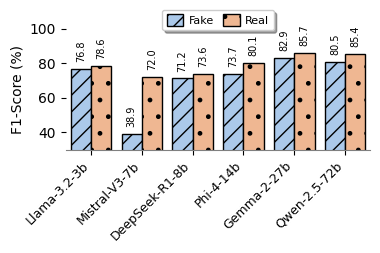

In [59]:
# classwise performance
classwise_plot_fake(df_fz,'4_fake_classwise_zero',y_limit=[30,100],save = True)

14


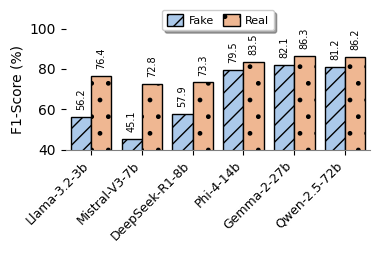

In [60]:
# classwise performance
classwise_plot_fake(df_ff,'4_fake_classwise_few',y_limit=[40,100],save = True)

### Confusion Matrix

In [26]:
## Confusion matrix function
def con_mat_fake(cm, class_names,model_name):
  #sns.set()
  plt.figure(figsize =(2, 1))
  ax = plt.subplot()
 # 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            #'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
  sns.heatmap(cm, annot=True,fmt="d",cmap='YlGnBu', ax = ax,
              annot_kws={"size": 11}, square=True,cbar=False) #annot=True to annotate cells
  # labels, title and ticks
  ax.set_xlabel('',fontsize=10)
  ax.set_ylabel('',fontsize=10)
  #ax.set_title(f'Confusion Matrix of {model_name}',fontsize=10)
  ax.xaxis.set_ticklabels(class_names, rotation=30,fontsize=8); ax.yaxis.set_ticklabels(class_names, rotation=30,fontsize=8);
  ax.xaxis.tick_top()
  plt.savefig(os.path.join(results_dir,f"{model_name}.png"),bbox_inches='tight',dpi =500)



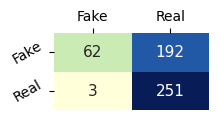

In [ ]:
## zero shot worst model
v_model = confusion_matrix(zero_fake['label'],zero_fake['mistral-7B'])
class_names =['Fake','Real']
con_mat_fake(v_model, class_names,"fake_mistral_conf")
#v_model

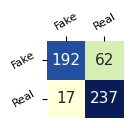

In [27]:
## zero shot best model
v_model = confusion_matrix(zero_fake['label'],zero_fake['gemma2-27B'])
class_names =['Fake','Real']
con_mat_fake(v_model, class_names,"4_fake_gemma_conf_zero")
#v_model

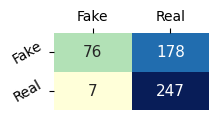

In [86]:
## few shot worst model

v_model = confusion_matrix(few_fake['label'],few_fake['mistral-7B'])
class_names =['Fake','Real']
con_mat_fake(v_model, class_names,"4_fake_mistral_conf_few")
#v_model

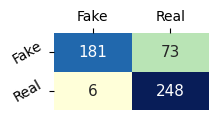

In [87]:
## few shot best model
v_model = confusion_matrix(few_fake['label'],few_fake['gemma2-27B'])
class_names =['Fake','Real']
con_mat_fake(v_model, class_names,"4_fake_gemma_conf_few")
#v_model

## Summary Chart

In [61]:
## sentiment analysis
sz = [('llama32-3B', '51.83'),('mistral-7B', '52.25'), ('deepseek-8B', '52.15'), ('phi4-14B', '60.28'), ('gemma2-27B', '61.54'), ('qwen-72B', '59.32')]
sf = [('llama32-3B', '57.19'),('mistral-7B', '49.71'), ('deepseek-8B', '51.71'), ('phi4-14B', '58.88'), ('gemma2-27B', '63.00'), ('qwen-72B', '61.30')]
# emotion recognition
ez = [('llama32-3B', '44.28'),('mistral-7B', '33.89'), ('deepseek-8B', '42.14'),('phi4-14B', '56.96'),('gemma2-27B', '58.40'), ('qwen-72B', '59.44')]
ef = [('llama32-3B', '47.12'), ('mistral-7B', '46.41'), ('deepseek-8B', '43.41'),('phi4-14B', '54.56'),('gemma2-27B', '60.27'),('qwen-72B', '65.86')]
# hate speech
hz = [('llama32-3B', '54.22'),('mistral-7B', '64.19'), ('deepseek-8B', '56.40'), ('phi4-14B', '72.17'),('gemma2-27B', '76.11'),('qwen-72B', '79.88')]
hf = [('llama32-3B', '62.85'),('mistral-7B', '63.07'), ('deepseek-8B', '61.47'),('phi4-14B', '70.56'),('gemma2-27B', '73.39'),('qwen-72B', '78.25')]
# fake news
fz = [('llama32-3B', '77.72'),('mistral-7B', '55.45'),('deepseek-8B', '72.39'),('phi4-14B', '76.91'),('gemma2-27B', '84.33'), ('qwen-72B', '82.91')]
ff = [('llama32-3B', '66.27'),('mistral-7B', '58.93'), ('deepseek-8B', '65.59'), ('phi4-14B', '81.48'), ('gemma2-27B', '84.17'),('qwen-72B', '83.68')]

In [62]:
# Combine your data
data = {
    ('Sentiment', 'zero-shot'): sz,
    ('Sentiment', 'few-shot'): sf,
    ('Emotion', 'zero-shot'): ez,
    ('Emotion', 'few-shot'): ef,
    ('Hate Speech', 'zero-shot'): hz,
    ('Hate Speech', 'few-shot'): hf,
    ('Fake News', 'zero-shot'): fz,
    ('Fake News', 'few-shot'): ff,
}

# Build a flat list of records
records = []
for (task, setting), values in data.items():
    for llm, score in values:
        records.append({
            "Dataset": task,
            "Setting": setting,
            "LLM": llm,
            "F1-Score": float(score)
        })

df = pd.DataFrame(records)
print(df.head())


     Dataset    Setting          LLM  F1-Score
0  Sentiment  zero-shot   llama32-3B     51.83
1  Sentiment  zero-shot   mistral-7B     52.25
2  Sentiment  zero-shot  deepseek-8B     52.15
3  Sentiment  zero-shot     phi4-14B     60.28
4  Sentiment  zero-shot   gemma2-27B     61.54


In [ ]:
df

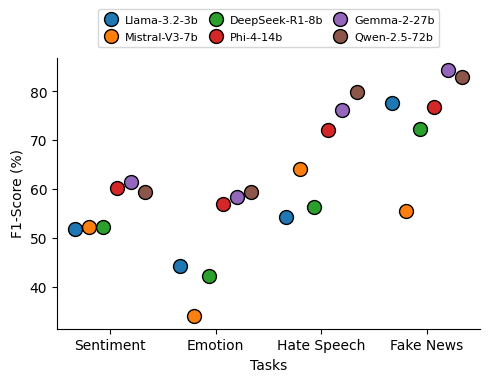

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(5, 4))
sns.stripplot(data=df[df["Setting"] == "zero-shot"], x="Dataset", y="F1-Score", hue="LLM", 
              jitter=2, dodge=1.5, size=10, palette="tab10",
              edgecolor="black",  # Border for each point
              linewidth=1)
# plt.title("Zero-shot Performance")
plt.xlabel('Tasks')
plt.ylabel("F1-Score (%)")

# Remove the figure border box
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)

# Relabel the legends
new_labels = ['Llama-3.2-3b', 'Mistral-V3-7b', 'DeepSeek-R1-8b', 'Phi-4-14b', 'Gemma-2-27b', 'Qwen-2.5-72b']
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=new_labels, loc='upper center', bbox_to_anchor=(0.5, 1.2),
           shadow=False, ncol=3, fontsize=8, handletextpad=0.5, columnspacing=0.8, handlelength=1.5, handleheight=1.2)


# Adjust layout and display the plot
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"5_zero_shot.png"),bbox_inches='tight',dpi =500)
plt.show()



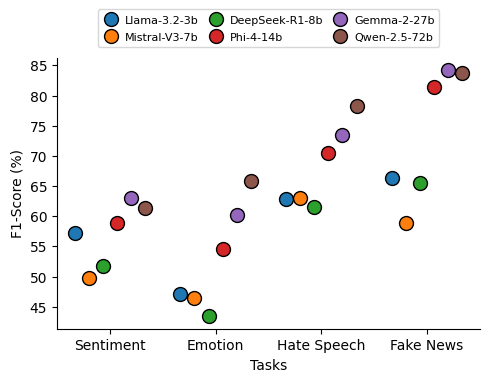

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(5, 4))
sns.stripplot(data=df[df["Setting"] == "few-shot"], x="Dataset", y="F1-Score", hue="LLM", 
              jitter=True, dodge=True, size=10, palette="tab10",
              edgecolor="black",  # Border for each point
              linewidth=1)
# plt.title("Zero-shot Performance")
plt.xlabel('Tasks')
plt.ylabel("F1-Score (%)")

# Remove the figure border box
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)

# Relabel the legends
new_labels = ['Llama-3.2-3b', 'Mistral-V3-7b', 'DeepSeek-R1-8b', 'Phi-4-14b', 'Gemma-2-27b', 'Qwen-2.5-72b']
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=new_labels, loc='upper center', bbox_to_anchor=(0.5, 1.2),
           shadow=False, ncol=3, fontsize=8, handletextpad=0.5, columnspacing=0.8, handlelength=1.5, handleheight=1.2)


# Adjust layout and display the plot
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"6_few_shot.png"),bbox_inches='tight',dpi =500)
plt.show()

